# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 7004 files belonging to 3 classes.
Found 859 files belonging to 3 classes.
Found 860 files belonging to 3 classes.


,broccoli,cauliflower,unknown,splits total
test,311,299,250,860
train,2595,2407,2002,7004
validate,311,298,250,859
img total,3217,3004,2502,8723


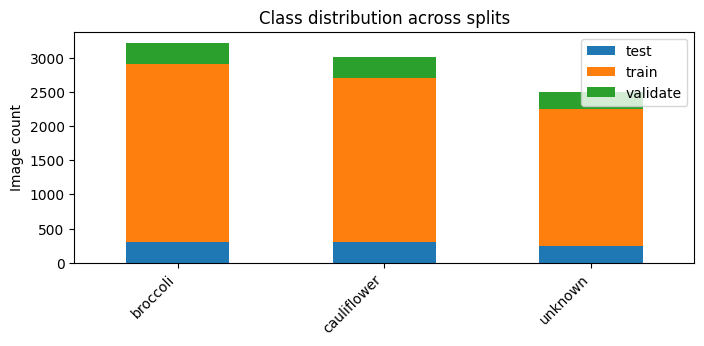

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

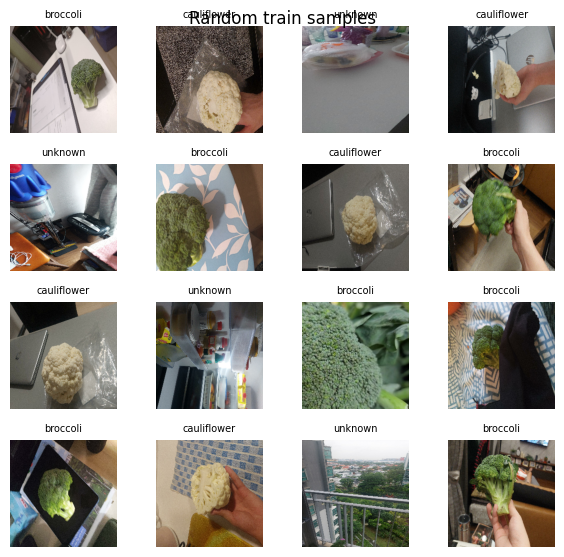

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom((0.3), 0.3),
    layers.RandomBrightness(0.2, value_range=(0, 1)),
    layers.RandomErasing(0.3, value_range=(0, 1))
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

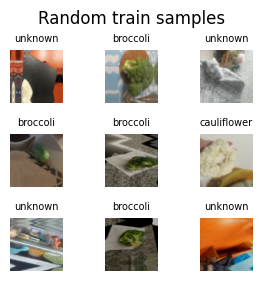

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

input = keras.Input(shape=(TARGET_SIZE, TARGET_SIZE,3))

gen9 = keras.models.load_model("../gen9/model.hdf5")
gen9_1 = keras.models.load_model("../gen8/model.hdf5")

gen9_1.name += "_1"
for layer in gen9_1.layers:
    layer.name += "_1"


gen9.trainable = False
gen9_1.trainable = False

x1 = gen9(input)
x2 = gen9_1(input)

x =layers.concatenate([x1, x2])

x = Dense(64, activation="relu")(x)

output = Dense(num_classes, activation="softmax")(x)

model = keras.Model(input, output)
model.summary(show_trainable=True)

Optimizer = optimizers.AdamW(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 100,     │         0 │ -              │   -   │
│ (InputLayer)      │ 100, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_2      │ (None, 3)       │ 1,605,763 │ input_layer_2… │   N   │
│ (Sequential)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ sequential_2_1    │ (None, 3)       │ 1,605,763 │ input_layer_2… │   N   │
│ (Sequential)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate       │ (None, 6)       │         0 │ sequential_2[… │   -   │
│ (Concatenate)     │                 │           │ sequential_2_… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense (Dense)     │ (None, 64)      │       448 │ concatenate[0… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_1 (Dense)   │ (None, 3)       │       195 │ dense[0][0]    │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 3,212,169 (12.25 MB)

 Trainable params: 643 (2.51 KB)

 Non-trainable params: 3,211,526 (12.25 MB)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=6,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights("model.weights.h5")
model.save("model.hdf5")

Epoch 1/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.4180 - loss: 1.0629 - val_accuracy: 0.6938 - val_loss: 0.8016
Epoch 2/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - accuracy: 0.8748 - loss: 0.7472 - val_accuracy: 0.9523 - val_loss: 0.5342
Epoch 3/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.9441 - loss: 0.5162 - val_accuracy: 0.9627 - val_loss: 0.3510
Epoch 4/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9532 - loss: 0.3515 - val_accuracy: 0.9651 - val_loss: 0.2412
Epoch 5/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9512 - loss: 0.2687 - val_accuracy: 0.9686 - val_loss: 0.1795
Epoch 6/6
28/28 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9481 - loss: 0.2199 - val_accuracy: 0.9686 - val_loss: 0.1440
Test loss: 0.151638001203537
Test accuracy: 0.9697674512863159


# Model Evalutation

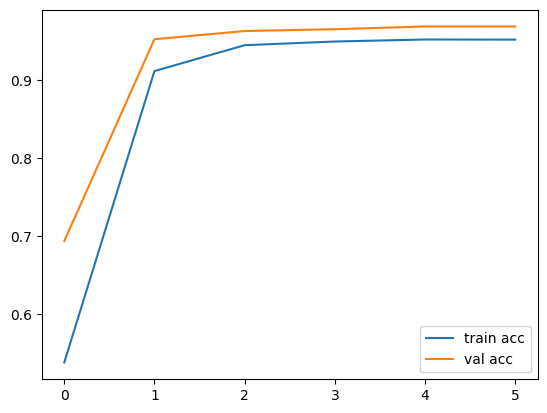

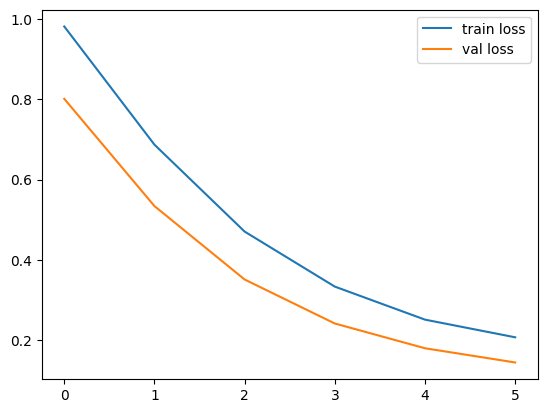

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Broccoli Precision:  0.9742765273311897
Broccoli Recall :  0.9837662337662337

Cauliflower Precision:  0.9899665551839465
Cauliflower Recall:  0.9548387096774194

Unknown Precision:  0.94
Unknown Recall:  0.9710743801652892


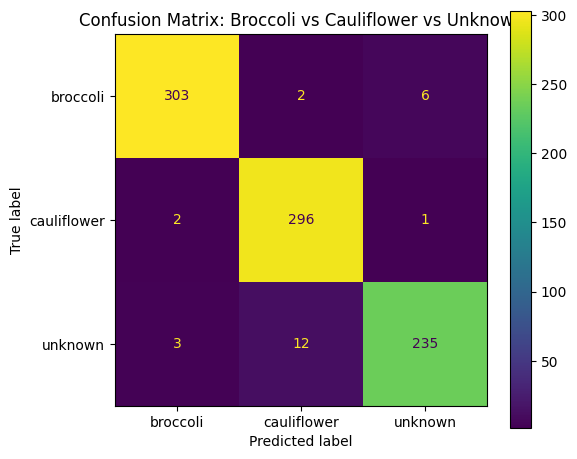

In [12]:
model = tf.keras.models.load_model('./model.hdf5')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
print()
print("Unknown Precision: ", cm[2][2] / cm[2].sum())
print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()